In [1]:
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git
import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas as pd #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

# comp-linguistics
import scipy
import spacy
import en_core_web_sm
import nltk

import warnings
warnings.filterwarnings('ignore')

unable to import 'smart_open.gcs', disabling that module


### Loading and Cleaning the data

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/liu431/Content-Analysis-Project/master/Data/output_review.csv")
df_meta = pd.read_csv("https://raw.githubusercontent.com/liu431/Content-Analysis-Project/master/Data/output_meta.csv")
df.head()

,Unnamed: 0,asin,title,overall,vote,verified,reviewTime,reviewerID,style,reviewerName,reviewText,summary,unixReviewTime,image
0,0,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,5.0,"1,113",True,"10 18, 2005",AILCWT1IIP7ZT,{'Style:': ' Retail'},Charles Chen,"As a software developer, I am literally attach...",Best Overall Keyboard to Date,1129593600,NaN
1,1,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,5.0,16,True,"10 12, 2005",A300T403J8526F,{'Style:': ' Retail'},T. Becker,"I've had a Natural Keyboard Pro for years, and...",Best keyboard I've used,1129075200,NaN
2,2,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,4.0,11,True,"10 5, 2005",AFPGV3IQ9K691,{'Style:': ' Retail'},GDC,"As with most Microsoft products, great hardwar...","Great keyboard, poor software.",1128470400,NaN
3,3,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,5.0,NaN,True,"05 15, 2018",A2FMMCFQ8702DN,{'Style:': ' Business'},Wickenball,Love it.,Five Stars,1526342400,NaN
4,4,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,5.0,NaN,True,"05 12, 2018",A1I8WBJSZIPJE0,{'Style:': ' Business'},B. Stearn,I've had various versions of this keyboard for...,Five Stars,1526083200,NaN


In [5]:
df_meta.head()

,Unnamed: 0,overall,asin,category,description,title,image,brand,feature,rank,main_cat,date,price,also_buy,also_view,similar_item,tech1,tech2,details,fit
0,92,2567,B000A6PPOK,"['Electronics', 'Computers & Accessories', 'Co...",['USB'],Microsoft Natural Ergonomic Keyboard 4000,['https://images-na.ssl-images-amazon.com/imag...,Microsoft,['Split ergonomic design encourages natural ha...,['>#222 in Computers & Accessories > Computer ...,All Electronics,"September 27, 2017",NaN,"['B00FPAVUHC', 'B0043T7FXE', 'B001F42MKG', 'B0...","['B075GZVD4T', 'B002MMY4WY', 'B00CYX26BC', 'B0...","[{'asin': '', 'href': '', 'name': 'Microsoft N...",NaN,NaN,NaN,NaN
1,191,1805,B00I0S6SK0,"['Electronics', 'Computers & Accessories', 'Co...",['The AZiO Vision keyboard features extra larg...,Azio Vision Backlit USB Keyboard with Large Pr...,['https://images-na.ssl-images-amazon.com/imag...,Azio,['Easy to see large print keys. 2x Larger than...,['>#56 in Computers & Accessories > Computer A...,Computers,"October 21, 2017",$2.54,"['B00ERV026K', 'B0787QZ6WD', 'B075WW7V6W', 'B0...","['B003VAGXWK', 'B00AGI7NKG', 'B007ZUC7DG', 'B0...","[{'asin': '', 'href': '', 'name': 'Azio Vision...",{'Number of USB 2.0 Ports': '1'},"{'Brand Name': 'Azio', 'Item model number': 'K...",NaN,NaN
2,501,1092,B00KF9IVKC,"['Electronics', 'Computers & Accessories', 'Co...",NaN,iPazzPort 3-color Backlit Wireless Mini Keyboa...,['https://images-na.ssl-images-amazon.com/imag...,iPazzPort,['3 in 1 multifunction 2.4ghz mini wireless qw...,['>#82 in Computers & Accessories > Computer A...,Computers,"June 23, 2017",$14.99,"['B07BCC8PK7', 'B06XHY5VXF', 'B0153R2A9I', 'B0...","['B015J6TEN8', 'B00Z81U3YY', 'B017N6J44G', 'B0...","[{'asin': '', 'href': '', 'name': 'iPazzPort 3...",NaN,NaN,NaN,NaN
3,1630,523,B00D9UTZWW,"['Electronics', 'Computers & Accessories', 'La...",NaN,"iBenzer MacBook Air 11 Inch Case, Soft Touch H...",['https://images-na.ssl-images-amazon.com/imag...,IBENZER,['Compatibility - MacBook Air 11 Inch model A1...,['>#259 in Computers & Accessories > Laptop Ac...,Computers,"August 28, 2017",$12.99,"['B01AJVYE9W', 'B00VVLE5CG', 'B007TA1YNQ', 'B0...","['B07L17HNZR', 'B07KQNHKVL', 'B00H0272VQ', 'B0...","[{'asin': '', 'href': '', 'name': 'iBenzer Mac...",NaN,NaN,NaN,NaN
4,1640,521,B00NG8EJOG,"['Electronics', 'Computers & Accessories', 'Ta...",['DUAL MODE CONNECTION 1. BLUETOOTH MODE: Pair...,"Foldable Bluetooth Keyboard, Jelly Comb B003B ...",['https://images-na.ssl-images-amazon.com/imag...,Jelly Comb,['FOLDING BLUETOOTH KEYBOARD: Bluetooth 3.0 te...,['>#37 in Computers & Accessories > Tablet Acc...,Computers,"April 27, 2017",$32.99,"['B07G723CB2', 'B079TL2TGY', 'B01HRIDPOA', 'B0...","['B018K5EJCQ', 'B078K1FFCP', 'B01MTVC775', 'B0...","[{'asin': '', 'href': '', 'name': 'Foldable Bl...",NaN,NaN,NaN,NaN


In [6]:
tbl = df.groupby('asin').agg({'overall':'count'})
tbl = tbl.sort_values(by = ['overall'], ascending = False)
tbl['asin'] = tbl.index
tbl = tbl.rename_axis("ID")
tbl

,overall,asin
ID,,
B000A6PPOK,2567,B000A6PPOK
B00I0S6SK0,1805,B00I0S6SK0
B00KF9IVKC,1092,B00KF9IVKC
B00D9UTZWW,523,B00D9UTZWW
B00NG8EJOG,521,B00NG8EJOG
B00E4TOWR0,418,B00E4TOWR0
B00O1B59AU,387,B00O1B59AU
B00LSGKEC4,378,B00LSGKEC4
B0194MC7JG,343,B0194MC7JG


In [7]:
df = df[df['reviewText'].notnull()]
df_agg = df.groupby(['asin', 'title'], as_index=False)[['reviewText']].agg(sum)
df_agg

,asin,title,reviewText
0,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,"As a software developer, I am literally attach..."
1,B004HJDUW0,Monoprice 32ft 10M USB 2.0 A Male to A Female ...,I have a LifeCam VX-5000 HD webcam on the end ...
2,B00D9UTZWW,"iBenzer MacBook Air 11 Inch Case, Soft Touch H...","Don't love the keyboard screen, but the case i..."
3,B00E4TOWR0,HP Wired USB Keyboard K1500 (Black) (H3C52AA#ABA),Love it. The keys are placed where I like the...
4,B00I0S6SK0,Azio Vision Backlit USB Keyboard with Large Pr...,This is just what I needed and it works great....
5,B00KF9IVKC,iPazzPort 3-color Backlit Wireless Mini Keyboa...,For $11.99 you can't go wrong. The keyboard ha...
6,B00LSGKEC4,Redragon K502 Gaming Keyboard RGB LED Backlit ...,"This would have been five stars, but I receive..."
7,B00NG8EJOG,"Foldable Bluetooth Keyboard, Jelly Comb B003B ...",Outstanding little bluetooth keyboard. I'm usi...
8,B00O1B59AU,"ZAGG Slim Book Ultrathin Case, Hinged with Det...",Zagg has really gone downhill in quality. I'v...
9,B0194MC7JG,Wireless Keyboard and Mouse - Jelly Comb K025 ...,I didn't think it would be possible with this ...


In [8]:
df_agg['tokenized_words'] = df_agg['reviewText'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
df_agg['normalized_words'] = df_agg['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))
df_agg

,asin,title,reviewText,tokenized_words,normalized_words
0,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,"As a software developer, I am literally attach...","[As, a, software, developer, I, am, literally,...","[software, developer, literally, attached, key..."
1,B004HJDUW0,Monoprice 32ft 10M USB 2.0 A Male to A Female ...,I have a LifeCam VX-5000 HD webcam on the end ...,"[I, have, a, LifeCam, VX-5000, HD, webcam, on,...","[lifecam, vx-5000, hd, webcam, end, dropped, f..."
2,B00D9UTZWW,"iBenzer MacBook Air 11 Inch Case, Soft Touch H...","Don't love the keyboard screen, but the case i...","[Do, n't, love, the, keyboard, screen, but, th...","[love, keyboard, screen, case, great, use, key..."
3,B00E4TOWR0,HP Wired USB Keyboard K1500 (Black) (H3C52AA#ABA),Love it. The keys are placed where I like the...,"[Love, it, The, keys, are, placed, where, I, l...","[love, keys, placed, like, bethis, keyboard, f..."
4,B00I0S6SK0,Azio Vision Backlit USB Keyboard with Large Pr...,This is just what I needed and it works great....,"[This, is, just, what, I, needed, and, it, wor...","[needed, works, great, lights, great, night, l..."
5,B00KF9IVKC,iPazzPort 3-color Backlit Wireless Mini Keyboa...,For $11.99 you can't go wrong. The keyboard ha...,"[For, $, 11.99, you, ca, n't, go, wrong, The, ...","[$, wrong, keyboard, nice, rubber, texture, fe..."
6,B00LSGKEC4,Redragon K502 Gaming Keyboard RGB LED Backlit ...,"This would have been five stars, but I receive...","[This, would, have, been, five, stars, but, I,...","[stars, received, bad, keyboard, initially, fu..."
7,B00NG8EJOG,"Foldable Bluetooth Keyboard, Jelly Comb B003B ...",Outstanding little bluetooth keyboard. I'm usi...,"[Outstanding, little, bluetooth, keyboard, I, ...","[outstanding, little, bluetooth, keyboard, m, ..."
8,B00O1B59AU,"ZAGG Slim Book Ultrathin Case, Hinged with Det...",Zagg has really gone downhill in quality. I'v...,"[Zagg, has, really, gone, downhill, in, qualit...","[zagg, gone, downhill, quality, ve, older, zag..."
9,B0194MC7JG,Wireless Keyboard and Mouse - Jelly Comb K025 ...,I didn't think it would be possible with this ...,"[I, did, n't, think, it, would, be, possible, ...","[think, possible, set, ve, day, desktop, compu..."


## EDA

HW1. Counting Words

In [10]:
# Counting words borrowed from materials
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pd.DataFrame(countsForFrame)

a. Counting: Most Frequent Words (normalized)

In [11]:
# Aggregate to a huge list
ls_normalized_words = []
for row in df_agg.iterrows():
    ls_normalized_words += row[-1]['normalized_words']
len(ls_normalized_words)

221685

In [12]:
df_words_count = wordCounter(ls_normalized_words)
df_words_count.sort_values('count', ascending=False, inplace=True)
df_words_count.head(10)

,word,count
4,keyboard,10169
66,keys,4241
12,use,2643
265,like,2377
298,great,2227
166,key,1934
52,good,1527
512,works,1498
151,work,1488
239,love,1283


In [14]:
df_words_count[df_words_count['word'] == 'microsoft']

,word,count
17,microsoft,713


b. Visualization (Lexical Plot and WordCloud)

In [43]:
import nltk
text = nltk.Text(ls_normalized_words)
index = nltk.text.ConcordanceIndex(text)
index.print_concordance('like')

Displaying 25 of 2377 matches:
s different difficult attachment come like keyboard feels typical ms periphrials
keyboard perfect makes type correctly like n key ve learned use m key correctly 
 uncomfortable placing hands keyboard like match heaven shame reach far away bre
g looking type seeing functioning way like kind alien technology look crappy pla
 forgotten personal preference course like slope keys makes leaving hands painle
ess comfortable prop ups conventional like size keyboard undeniably largest keyb
s saved wrists!pefect meplugged works like champ keyboard takes getting use setu
getting use setup favors larger hands like traditional layout special keys work 
special keys work box windows machine like key weight quiet silent overall happy
dhas installed year working expectedi like like split half key board like challe
installed year working expectedi like like split half key board like challenge y
ectedi like like split half key board like challenge yea buy stick use love it

C:\Users\qmun\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
C:\Users\qmun\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
C:\Users\qmun\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
C:\Users\qmun\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
C:\Users\qmun\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in 

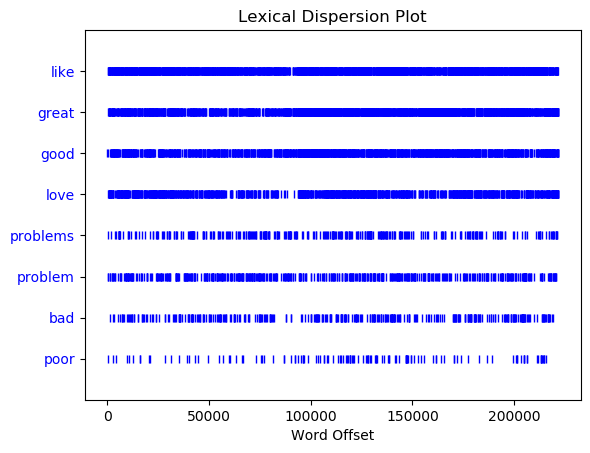

In [62]:
# Display results of "like", 'don't like'
ls_keyword = ['like', 'great', 'good', 'love', 'problems', 'problem', 'bad', 'poor']
sns.reset_orig() #Seaborn messes with this plot, disabling it
text.dispersion_plot(ls_keyword)
sns.set() #Re-enabling seaborn

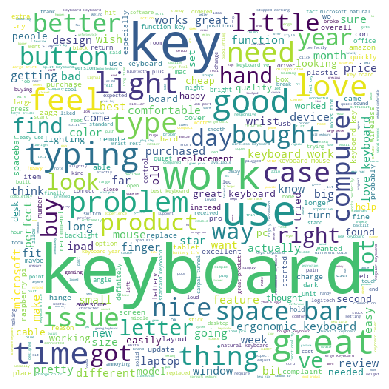

In [64]:
# Word Cloud
import wordcloud
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(df_agg['normalized_words'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("song_lyrics_word_cloud.pdf", format = 'pdf')

c. Sentimental Analysis

In [65]:
df_agg

,asin,title,reviewText,tokenized_words,normalized_words
0,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,"As a software developer, I am literally attach...","[As, a, software, developer, I, am, literally,...","[software, developer, literally, attached, key..."
1,B004HJDUW0,Monoprice 32ft 10M USB 2.0 A Male to A Female ...,I have a LifeCam VX-5000 HD webcam on the end ...,"[I, have, a, LifeCam, VX-5000, HD, webcam, on,...","[lifecam, vx-5000, hd, webcam, end, dropped, f..."
2,B00D9UTZWW,"iBenzer MacBook Air 11 Inch Case, Soft Touch H...","Don't love the keyboard screen, but the case i...","[Do, n't, love, the, keyboard, screen, but, th...","[love, keyboard, screen, case, great, use, key..."
3,B00E4TOWR0,HP Wired USB Keyboard K1500 (Black) (H3C52AA#ABA),Love it. The keys are placed where I like the...,"[Love, it, The, keys, are, placed, where, I, l...","[love, keys, placed, like, bethis, keyboard, f..."
4,B00I0S6SK0,Azio Vision Backlit USB Keyboard with Large Pr...,This is just what I needed and it works great....,"[This, is, just, what, I, needed, and, it, wor...","[needed, works, great, lights, great, night, l..."
5,B00KF9IVKC,iPazzPort 3-color Backlit Wireless Mini Keyboa...,For $11.99 you can't go wrong. The keyboard ha...,"[For, $, 11.99, you, ca, n't, go, wrong, The, ...","[$, wrong, keyboard, nice, rubber, texture, fe..."
6,B00LSGKEC4,Redragon K502 Gaming Keyboard RGB LED Backlit ...,"This would have been five stars, but I receive...","[This, would, have, been, five, stars, but, I,...","[stars, received, bad, keyboard, initially, fu..."
7,B00NG8EJOG,"Foldable Bluetooth Keyboard, Jelly Comb B003B ...",Outstanding little bluetooth keyboard. I'm usi...,"[Outstanding, little, bluetooth, keyboard, I, ...","[outstanding, little, bluetooth, keyboard, m, ..."
8,B00O1B59AU,"ZAGG Slim Book Ultrathin Case, Hinged with Det...",Zagg has really gone downhill in quality. I'v...,"[Zagg, has, really, gone, downhill, in, qualit...","[zagg, gone, downhill, quality, ve, older, zag..."
9,B0194MC7JG,Wireless Keyboard and Mouse - Jelly Comb K025 ...,I didn't think it would be possible with this ...,"[I, did, n't, think, it, would, be, possible, ...","[think, possible, set, ve, day, desktop, compu..."


In [83]:
# Overall Sentiment Score
from textblob import TextBlob

df_agg['sentiment'] = float(0)
for index, row in df_agg.iterrows():
    obj = TextBlob(' '.join(df_agg['normalized_words'][index]))
    sentiment = obj.sentiment.polarity
    df_agg['sentiment'][index] = sentiment
df_senti = df_agg[['asin', 'sentiment']].sort_values('sentiment', ascending=False)
df_senti

,asin,sentiment
2,B00D9UTZWW,0.284910
5,B00KF9IVKC,0.236993
3,B00E4TOWR0,0.234817
1,B004HJDUW0,0.231740
7,B00NG8EJOG,0.218203
9,B0194MC7JG,0.212755
4,B00I0S6SK0,0.209287
6,B00LSGKEC4,0.192071
8,B00O1B59AU,0.167877
0,B000A6PPOK,0.156950


In [86]:
df['tokenized_words'] = df['reviewText'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
df['normalized_words'] = df['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))
df.head()

,Unnamed: 0,asin,title,overall,vote,verified,reviewTime,reviewerID,style,reviewerName,reviewText,summary,unixReviewTime,image,tokenized_words,normalized_words
0,0,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,5.0,"1,113",True,"10 18, 2005",AILCWT1IIP7ZT,{'Style:': ' Retail'},Charles Chen,"As a software developer, I am literally attach...",Best Overall Keyboard to Date,1129593600,NaN,"[As, a, software, developer, I, am, literally,...","[software, developer, literally, attached, key..."
1,1,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,5.0,16,True,"10 12, 2005",A300T403J8526F,{'Style:': ' Retail'},T. Becker,"I've had a Natural Keyboard Pro for years, and...",Best keyboard I've used,1129075200,NaN,"[I, 've, had, a, Natural, Keyboard, Pro, for, ...","[ve, natural, keyboard, pro, years, use, work,..."
2,2,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,4.0,11,True,"10 5, 2005",AFPGV3IQ9K691,{'Style:': ' Retail'},GDC,"As with most Microsoft products, great hardwar...","Great keyboard, poor software.",1128470400,NaN,"[As, with, most, Microsoft, products, great, h...","[microsoft, products, great, hardware, poor, s..."
3,3,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,5.0,NaN,True,"05 15, 2018",A2FMMCFQ8702DN,{'Style:': ' Business'},Wickenball,Love it.,Five Stars,1526342400,NaN,"[Love, it]",[love]
4,4,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,5.0,NaN,True,"05 12, 2018",A1I8WBJSZIPJE0,{'Style:': ' Business'},B. Stearn,I've had various versions of this keyboard for...,Five Stars,1526083200,NaN,"[I, 've, had, various, versions, of, this, key...","[ve, versions, keyboard, 20years, saved, wrists]"


In [90]:
# Calculating Sentiment for each review
df['sentiment'] = float(0)
for index, row in df.iterrows():
    obj = TextBlob(' '.join(df['normalized_words'][index]))
    sentiment = obj.sentiment.polarity
    df['sentiment'][index] = sentiment
df_senti_2 = df[['asin', 'sentiment']]
df_senti_2 = df_senti_2.groupby('asin').mean().sort_values('sentiment', ascending=False)
df_senti_2

,sentiment
asin,
B00D9UTZWW,0.376875
B00KF9IVKC,0.330764
B00E4TOWR0,0.321587
B004HJDUW0,0.297662
B0194MC7JG,0.294846
B00NG8EJOG,0.286377
B00I0S6SK0,0.280618
B00LSGKEC4,0.252751
B00O1B59AU,0.238371


These two sentimental analysis are consistent with each other, with the same product of highest and lowest sentiment scores in both two analysis.

## d. Network Analysis and topic extraction

In [18]:
df_meta['brand']

0     Microsoft
1          Azio
2     iPazzPort
3       IBENZER
4    Jelly Comb
5            HP
6          ZAGG
7      Redragon
8    Jelly Comb
9     Monoprice
Name: brand, dtype: object

In [59]:
# Find keywords
# We can set the keywords just changed the list
ls_keywords = ['microsoft', 'zagg', 'keyboard', 'key', 'great', 'like', 'problem', 'bad']
dool = []
for index, row in df_agg.iterrows():
    dool += df_agg['normalized_words'][index]

characters = {}
for token in dool:
    if token in ls_keywords:
        # all characters or actions start with @, so we add that to character
        if token not in characters:
            characters[token] = 0
        if token in characters:
            characters[token] += 1
characters

{'keyboard': 10169,
 'microsoft': 713,
 'problem': 537,
 'key': 1934,
 'like': 2377,
 'great': 2227,
 'bad': 344,
 'zagg': 257}

In [43]:
import networkx as nx

In [45]:
actor_network = nx.Graph()

In [46]:
for character in characters:
    actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [47]:
i = 0
all_texts = []

In [48]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token in ls_keywords:
        if token in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_ in ls_keywords:
                    # if both the characters exist in the graph, add a weight
                    if token_ != token and token_ in actor_network.nodes():
                        if (token, token_) not in actor_network.edges():
                            actor_network.add_edge(token, token_, weight=0)
                        if (token, token_) in actor_network.edges():
                            actor_network.edges[(token, token_)]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token]['words'].append(dool[i:j])
            all_texts.append(lucem_illud_2020.normalizeTokens(dool[i:j]))

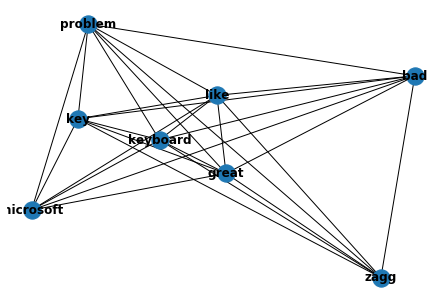

In [49]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

As we can see from the network analysis, keyboards and key are in the central, having huge connection with others, which matches with its huge frequency. It is interesting that compared with zagg, Microsoft has more connection with problems hhh. 

In [50]:
all_texts[:10]

[['typical', 'day', 'spend', 'hour', 'type', 'critical', 'importance'],
 ['use', 'comfortable', 'programmer', 'typist', 'attest'],
 ['ergo', 'series', 'keyboard', 'well'],
 ['prolong',
  'use',
  'have',
  'ergo',
  'keyboard',
  'form',
  'past',
  'year',
  'recently',
  'wireless',
  'elite',
  'set'],
 ['step', 'begin', 'construction', 'solid', 'far', 'flex', 'plastic'],
 ['compare',
  'wireless',
  'elite',
  'wrist',
  'pad',
  'nicely',
  'texture',
  'faux',
  'leather',
  'material',
  'tiny',
  'bite',
  'pad',
  'feel',
  'durable',
  'mention',
  'comfortable',
  'good',
  'addition',
  'main',
  'gripe',
  'ms',
  'ergo',
  'keyboard',
  'hard',
  'fit',
  'gel',
  'wrist',
  'rest',
  'curve',
  'base'],
 ['compare', 'previous', 'ms', 'keyboard', 'have', 'own', 'key'],
 ['damp',
  'term',
  'sound',
  'produce',
  'mute',
  'hard',
  'stroke',
  'thing',
  'adjust',
  'increase',
  'curvature',
  'different',
  'plane',
  'pinky',
  'index',
  'finger',
  'rest',
  'f',
 

In [51]:
dictionary = gensim.corpora.Dictionary(all_texts)
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [52]:
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')
doollda.show_topics()

[(0,
  '0.052*"good" + 0.049*"quiet" + 0.045*"feel" + 0.018*"plastic" + 0.017*"macbook" + 0.016*"air" + 0.015*"key" + 0.014*"quality" + 0.013*"color" + 0.013*"choice"'),
 (1,
  '0.032*"time" + 0.024*"product" + 0.021*"buy" + 0.021*"recommend" + 0.020*"type" + 0.017*"use" + 0.014*"need" + 0.013*"well" + 0.012*"work" + 0.012*"long"'),
 (2,
  '0.038*"key" + 0.030*"nice" + 0.026*"set" + 0.024*"easy" + 0.016*"remote" + 0.016*"size" + 0.013*"touch" + 0.012*"wireless" + 0.012*"type" + 0.011*"use"'),
 (3,
  '0.020*"mini" + 0.019*"bluetooth" + 0.019*"use" + 0.014*"good" + 0.013*"red" + 0.013*"size" + 0.013*"product" + 0.013*"star" + 0.012*"ipad" + 0.011*"work"'),
 (4,
  '0.035*"love" + 0.032*"product" + 0.016*"=" + 0.016*"mouse" + 0.015*"link" + 0.013*"stand" + 0.013*"key" + 0.012*"hand" + 0.012*"well" + 0.011*"fn"'),
 (5,
  '0.030*"key" + 0.019*"compact" + 0.017*"letter" + 0.015*"review" + 0.015*"battery" + 0.015*"use" + 0.013*"feel" + 0.011*"price" + 0.011*"issue" + 0.011*"cheap"'),
 (6,
  '0

In [53]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud_2020.normalizeTokens(actor_all_words))]

In [54]:
for actor in actor_network.nodes():
    print(actor, actor_network.nodes[actor]['topic_distribution'])

keyboard [(2, 0.016884696), (3, 0.042031925), (4, 0.045665167), (5, 0.24840163), (6, 0.064605795), (7, 0.09063084), (9, 0.49177948)]
microsoft [(2, 0.015842358), (3, 0.045686718), (4, 0.045002416), (5, 0.26139152), (6, 0.059267458), (7, 0.09798535), (9, 0.4748158)]
problem [(2, 0.01609411), (3, 0.04205653), (4, 0.050827637), (5, 0.24073128), (6, 0.06989063), (7, 0.0871468), (9, 0.49324518)]
key [(2, 0.014887595), (3, 0.04088149), (4, 0.047551207), (5, 0.2545118), (6, 0.062301263), (7, 0.088367976), (9, 0.49149615)]
like [(2, 0.016930643), (3, 0.0415425), (4, 0.04842464), (5, 0.24188219), (6, 0.06361708), (7, 0.09263394), (9, 0.49496713)]
great [(2, 0.017560706), (3, 0.043613084), (4, 0.05089452), (5, 0.2465013), (6, 0.06714978), (7, 0.095226385), (9, 0.47905225)]
bad [(2, 0.015563126), (3, 0.039831728), (4, 0.04854406), (5, 0.24461597), (6, 0.06354579), (7, 0.09042095), (9, 0.4974647)]
zagg [(2, 0.018342473), (3, 0.04076313), (4, 0.052602768), (5, 0.2614869), (6, 0.076712884), (7, 0.08

In [55]:
from gensim.matutils import kullback_leibler
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [56]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution'] 
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

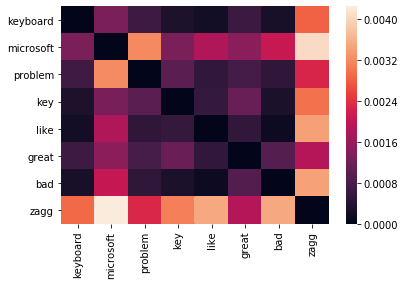

In [58]:
fig = plt.figure()
div = pd.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

We can easily differ zagg compared with other topic extraction, but hard to make a difference among other topics.